## Fit a DelayedSaturatedMMM with TVP
There are many ways to use time-varying parameters in an MMM. Here are some things one might want to do with TVP in MMM:
1) Time-varying intercept
2) Single time-varying parameter that models a time-varying factor which modulates total effect of media spend. Like `mu = media_contribution.sum(-1) * time_varying_factor + ...`
3) Each (or selected) channel `beta`s are seperate time-varying coefficients. This is the most flexible and general approach, and probably the most desired out there, but it's also somewhat unweildy and can very easily overfit to noise. The best approach when doing this is to have a hierarchical hyperprior 
4) 
... and 1 and 2 are not mutually exclusive.

In this notebook I demonstrate the use of 2.

In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import pymc as pm

from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

In [2]:
pd.set_option('display.max_columns', None)

## Create some data for testing

#### → Load input (channel spend/impressions and control data)

In [3]:
# Load some synthetic impression+control data
data = pd.read_csv("mock_cgp_data-no-target.csv", parse_dates=["Weeks"])

# Define which columns are media and control
coords = {
    "media": ["Google Search", "DV360", "Facebook", "AMS", "TV", "VOD", "OOH", "Radio"],
    "control": ["Numeric Distribution", "RSP", "Promotion"],
    "week": data["Weeks"],
}

#### → Simulate a target (e.g. sales)

<Axes: title={'center': 'Target'}>

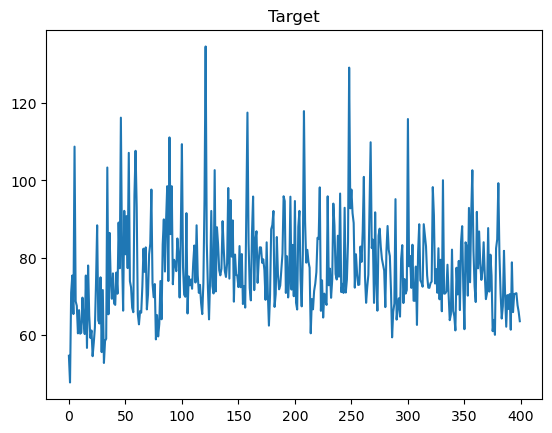

In [4]:
# Create the model, with channel spend, control variables, adstock, and yearly seasonality
mmm = DelayedSaturatedMMM(
    date_column="Weeks",
    channel_columns=coords["media"],
    control_columns=coords["control"],
    adstock_max_lag=10,
    time_varying_intercept=True,
    sampler_config={"nuts_sampler": "numpyro"},
)

true_params = {
    "intercept": (np.cos(np.arange(data.shape[0]) / 52.18 * 2 * np.pi) / 2 + 1)
    * 5,  # putting yearly seasonality in intercept
    "beta_channel": (data[coords["media"]].max(0)).values
    * np.array([3.5, 2.0, 5.0, 3.2, 1.5, 2.0, 1.0, 1.5])
    * 7,
    "alpha": np.array([0, 0.5, 0.1, 0.1, 0.9, 0.5, 0.9, 0.95]),
    "lam": 1 / (data[coords["media"]].mean(0)).values,
    "likelihood_sigma": 0.25,
    "gamma_control": np.array([-0.5, 1, 0.25]),
}

mmm.build_model(data, np.ones(data.shape[0]))

true_model = pm.do(
    mmm.model,
    true_params,
)

plt.title("Target")
data["target"] = pm.draw(true_model.y)
data["target"].plot()

#### → Split into train and test

In [5]:
# Split into train and test
data_train = data.iloc[:-52]
data_test = data.iloc[-52:]

## Fit a DelayedSaturatedMMM with TVP

#### → Fit the model

In [6]:
mmm = DelayedSaturatedMMM(
    date_column="Weeks",
    channel_columns=coords["media"],
    control_columns=coords["control"],
    adstock_max_lag=10,
    time_varying_intercept=True,
    sampler_config={"chains": 2, "draws": 10, "tune": 10, "nuts_sampler": "numpyro"},
)
# mmm.build_model(data_train, data_train["target"].values)
mmm.fit(data_train, data_train["target"])

Only 10 samples in chain.
Compiling...
Compilation time = 0:00:02.353575
Sampling...


  0%|          | 0/1010 [00:00<?, ?it/s]

  0%|          | 0/1010 [00:00<?, ?it/s]

Sampling time = 0:01:20.477423
Transforming variables...
Transformation time = 0:00:00.698495


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

#### → Diagnose it

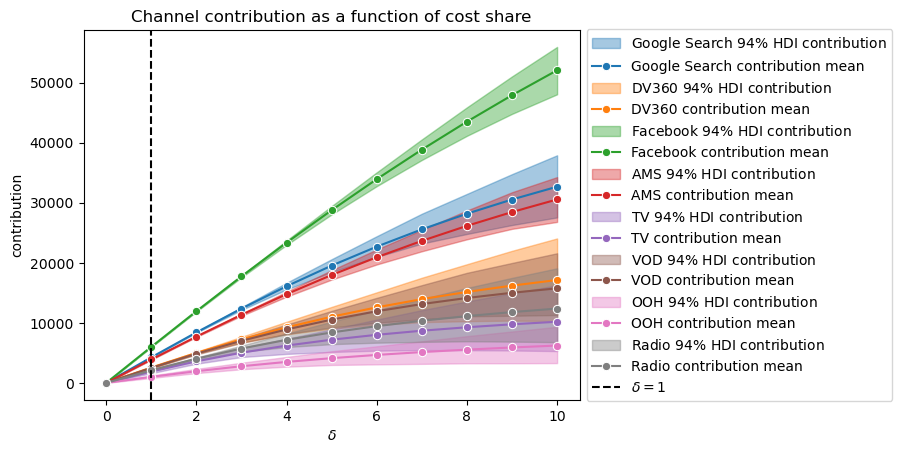

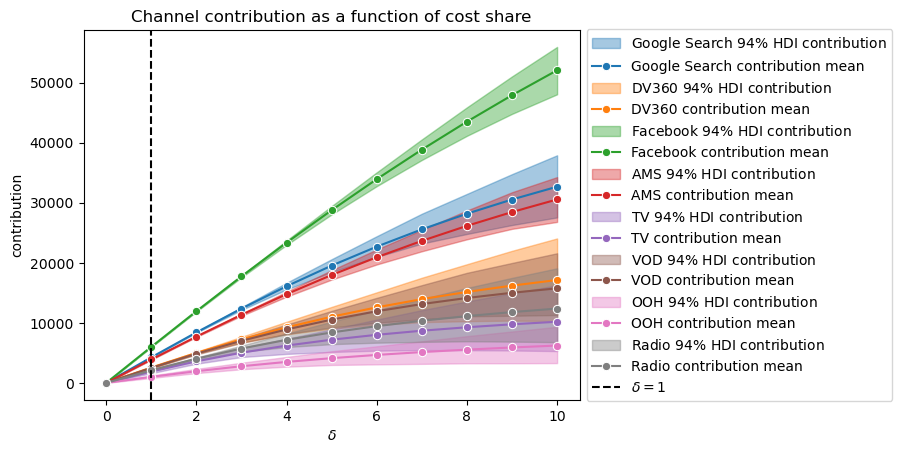

In [41]:
mmm.plot_channel_contributions_grid(0, 10, 11)

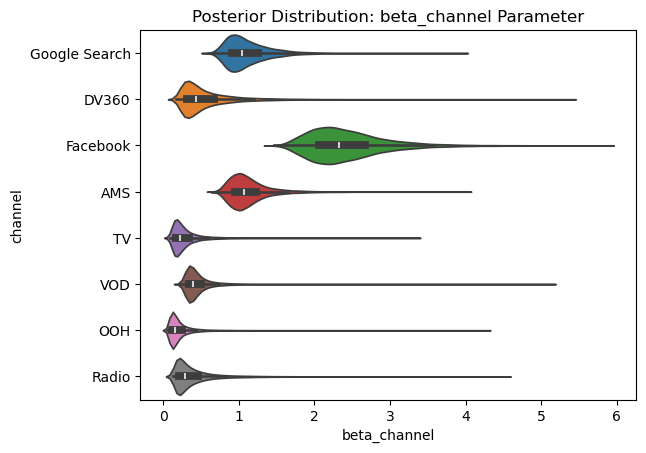

In [42]:
_ = mmm.plot_channel_parameter('beta_channel')

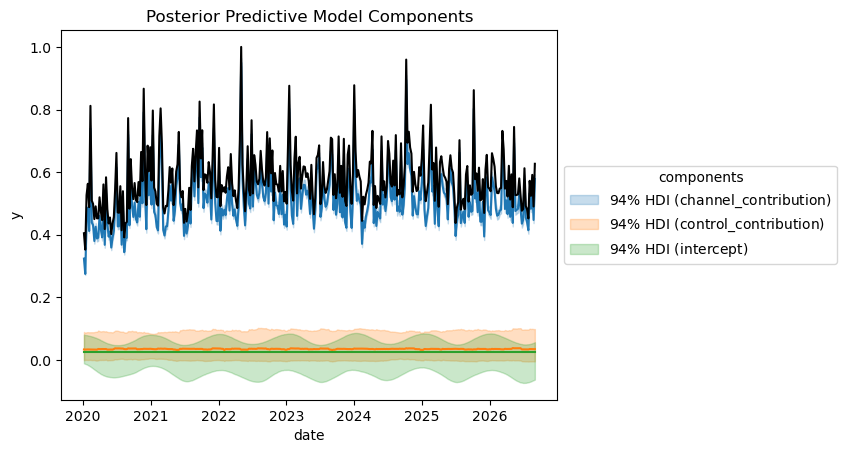

In [43]:
_ = mmm.plot_components_contributions()

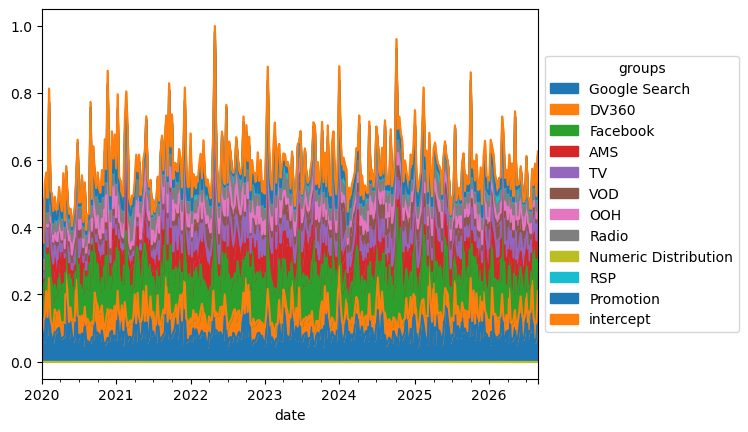

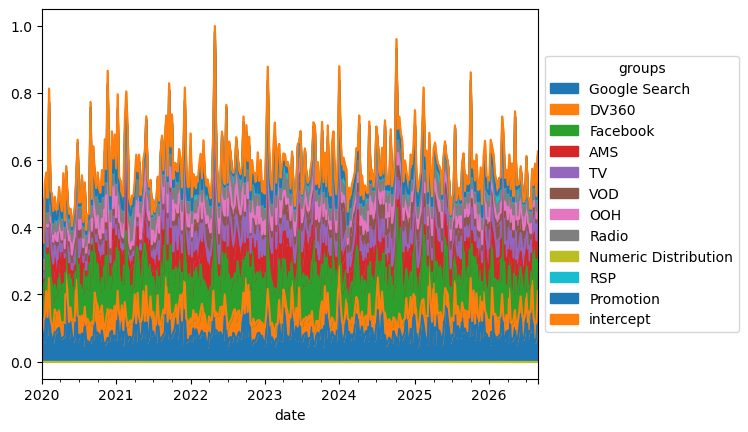

In [44]:
mmm.plot_grouped_contribution_breakdown_over_time()

#### → Plot out of sample predictive

Sampling: [y]


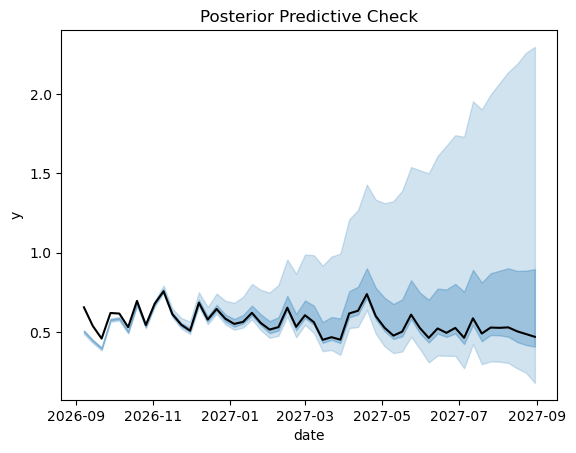

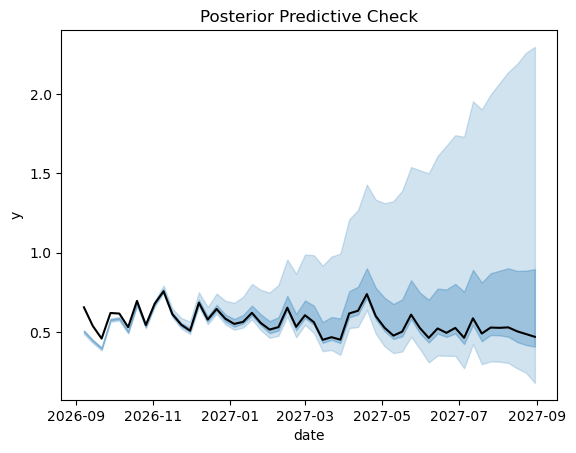

In [45]:
mmm.sample_posterior_predictive(X_pred=data_test)
mmm.y = data_test["target"].values
mmm.plot_posterior_predictive()

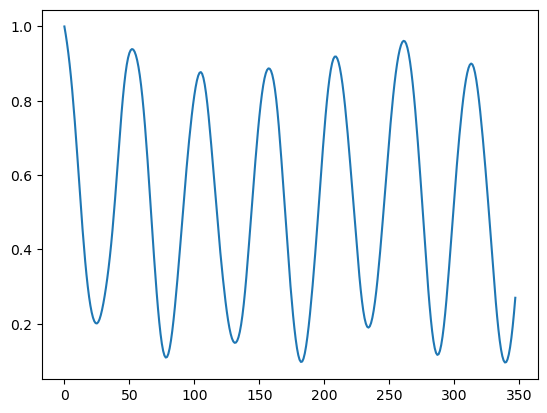

In [66]:
plt.plot(mmm.max_abs_scale_target_data(mmm.idata.posterior.intercept.mean(axis=(0, 1)).data))